In [182]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from fastai.text import *
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Loading and Visualization of distribution of the Data

In [183]:
df = pd.read_csv('../input/twitter-airline-sentiment/Tweets.csv')

In [184]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


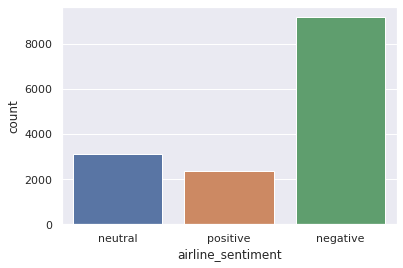

In [185]:
# Distribution of the respective 3 sentiments.
sns.set(style="darkgrid")
ax = sns.countplot(x="airline_sentiment", data=df)

[Text(0, 0, 'Bad Flight'),
 Text(0, 0, "Can't Tell"),
 Text(0, 0, 'Late Flight'),
 Text(0, 0, 'Customer Service Issue'),
 Text(0, 0, 'Flight Booking Problems'),
 Text(0, 0, 'Lost Luggage'),
 Text(0, 0, 'Flight Attendant Complaints'),
 Text(0, 0, 'Cancelled Flight'),
 Text(0, 0, 'Damaged Luggage'),
 Text(0, 0, 'longlines')]

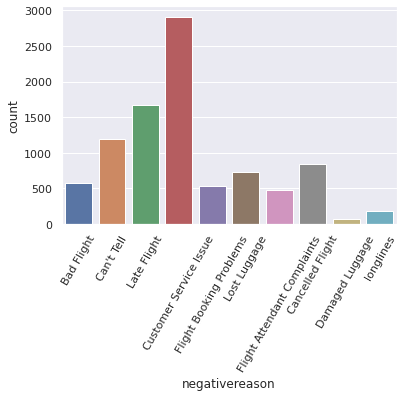

In [186]:
# Distribution of the negative sentiment.
ax = sns.countplot(x='negativereason',data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)


# **Preprocessing the Twitter data**
The decisions in which to preprocess were based on intuitions (for example, our assumption is that removing a hashtag would reduce noise and improve signal), as well as research paper results (removing numbers, replacing urls, and replacing user mentions were shown to improve accuracy on Twitter Sentiment Analysis).
This is based on the code from "A Comparison of Pre-processing Techniques for Twitter Sentiment Analysis" by Dimotrios Effrosynidis.

In [187]:
import re

def removeUnicode(text):
  """ Removes unicode strings like "\u002c" and "x96" """
  text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
  text = re.sub(r'[^\x00-\x7f]',r'',text)
  return text
  
def replaceURL(text):
  """Replaces url address with "url" """
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
  text = re.sub(r'#([^\s]+)', r'\1', text)
  return text

def replaceAtUser(text):
  """ Replaces "@user" with "atUser" """
  # text = re.sub('@[^\s]+','atUser',text)
  text = re.sub('@[^\s]+','',text)
  return text

def removeHashtagInFrontOfWord(text):
  """ Removes hastag in front of a word """
  text = re.sub(r'#([^\s]+)', r'\1', text)
  return text

def removeNumbers(text):
  """ Removes integers """
  text = ''.join([i for i in text if not i.isdigit()])         
  return text

def removeEmoticons(text):
  """ Removes emoticons from text """
  text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
  return text


""" Replaces contractions from a string to their equivalents """
contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
def replaceContraction(text):
  patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
  for (pattern, repl) in patterns:
      (text, count) = re.subn(pattern, repl, text)
  return text

In [188]:
def preprocessTwitterData(df):
  """Function to apply text preprocessing functions to a dataframe"""
  
  # remove unicode
  df['text'] = df['text'].apply(removeUnicode)
  
  # replace url
  df['text'] = df['text'].apply(replaceURL)
  
  # replace '@' signs
  df['text'] = df['text'].apply(replaceAtUser)
  
  
  # replace hastags
  df['text'] = df['text'].apply(removeHashtagInFrontOfWord)
  
  # remove numbers in the tweets
  df['text'] = df['text'].apply(removeNumbers)
  
  # remove the emoticons
  df['text'] = df['text'].apply(removeEmoticons)
  
  # replace contractions
  df['text'] = df['text'].apply(replaceContraction)
  
# Call the function and preprocess the data  
preprocessTwitterData(df)

# Since we don't need the rest of the columns in the data, subindex the relevant columns and make this the new dataframe
df = df[['text','airline_sentiment']]

# Split the dataset into a train and test set.
# Using a validation set is built into the fastai API, so we don't need to do this split ourselves

# use an 80-20 split for the train and test sets
df_train, df_test = train_test_split(df,test_size=0.1,random_state=20)

# Convert the cleaned training and testing data into their own CSV files which we can import later to perform modeling on them

df_train.to_csv('twitter_data_cleaned_train.csv')
df_test.to_csv('twitter_data_cleaned_test.csv')

# Training Phase
First we will have a language model and then add a classification model for enhanced results.

In [189]:
# Create a 'TextLMDataBunch' from a csv file.
# We specify 'valid=0.1' to signify that when we want to actually put this into our language model, we'll be setting off 10% of it for a validation set
data_batch = TextLMDataBunch.from_csv(path='',csv_name='twitter_data_cleaned_train.csv',valid_pct=0.1)

# run this to see how the batch looks like
data_batch.show_batch()

idx,text
0,"experience in xxmaj denver ! xxmaj instead of landing in xxup sea on xxmaj saturday , now it is xxmaj monday afternoon ! xxbos placed on hold for total of two hours today after flight was xxmaj cancelled xxmaj flightled . xxmaj online option not available . xxmaj what to do ? xxbos xxmaj lost black wallet at xxunk . i was on flight to xxunk appreciate ur help ."
1,can see . xxmaj very sad . xxmaj thanks for nothing . xxmaj worst airline ever . xxbos xxmaj supposed to take off almost hours ago xxrep 4 . xxunk xxunk ? xxunk xxunk xxbos sitting in xxmaj newark because flight was xxmaj cancelled xxmaj flightled for no apparent reason . xxmaj all i was told was sorry after . hrs waiting xxbos any direct number to dividend miles account
2,you . xxbos can u help this needs urgent treatment xxunk old xxunk xxunk could u help with flights freyasfund xxbos has been almost a month and still no response to my online complaint / questions . xxmaj out $ because of it . xxbos already did that at the airport and hrs xxmaj late xxmaj flightr its still not here ! you guys are really killing me today .
3,"at xxmaj tampa xxmaj airport forever today ! ! ! xxmaj it is really been an awesome experience xxbos xxup xxunk xxup one xxup by xxup one xxbos xxup us . xxmaj refuel ; we have sat for so long . xxmaj pilot announces where the truck is . "" xxmaj look , over there to the left ! "" xxmaj actual announcement . xxbos what is the point of"
4,those playing along at home url xxbos xxup dm sent as requested . xxmaj make sure you follow back so you can xxup dm me back . xxmaj thanks xxbos is there a xxunk to check delays / xxmaj cancelled xxmaj flightlations out of xxmaj love xxmaj field ? xxmaj flying out tomorrow am and stressed about weather ! xxbos xxmaj will flights be leaving xxmaj dallas for xxup la


Initially we gonna set a language model ,train it and save the encodings i.e weights

In [190]:
# pass in our 'data_lm' objet to specify our Twitter data
# pass in AWD_LSTM to specify that we're using this particular language model
tweet_model = language_model_learner(data_batch, AWD_LSTM, drop_mult=0.3)

In [191]:
tweet_model.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(5216, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(5216, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=5216, bias=True)
    (output_dp): RNNDropout()
  )
)

In [192]:
# fastai learning-rate finding
# implemented using fastai callbacks
#learning_rate_finder is used to find the optimal learning rate .
tweet_model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


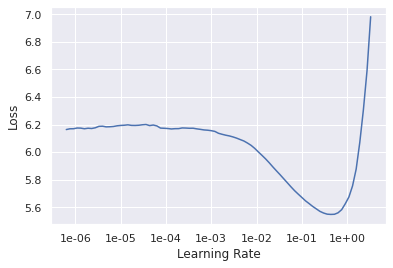

In [193]:
# plot the graph we were talking about earlier
tweet_model.recorder.plot()

From the graph, we shall decide to take 1e-1 since the learning rate as the loss becomes minimum after this.


In [194]:
# We set cycle_len to 1 because we only train with one epoch 'moms' refers to a tuple with the form (max_momentum,min_momentum)
tweet_model.fit_one_cycle(cyc_len=1,max_lr=1e-1,moms=(0.85,0.75))

epoch,train_loss,valid_loss,accuracy,time
0,4.656074,4.191497,0.238329,00:06


In [195]:
# unfreeze the LSTM layers of the model
tweet_model.unfreeze()

In [196]:
#Now let's train the model
tweet_model.fit_one_cycle(cyc_len=5, max_lr=slice(1e-1/(2.6**4),1e-1), moms=(0.85, 0.75))

epoch,train_loss,valid_loss,accuracy,time
0,4.025440,4.167947,0.227360,00:07
1,3.977228,4.039382,0.257844,00:07
2,3.692686,4.032982,0.265019,00:07
3,3.141062,4.113965,0.269324,00:07
4,2.398415,4.476751,0.261798,00:07


In [197]:
# save the encoder 
tweet_model.save_encoder('encoder')

Now let's change the model according to our application i.e classification.

In [198]:
# create 'TextClasDataBunch'
# pass in vocab to ensure the vocab is the
# same one that was modified in the fine-tuned LM
data_class = TextClasDataBunch.from_csv(path='',csv_name='twitter_data_cleaned_train.csv',
                              vocab=data_batch.train_ds.vocab,bs=32,text_cols='text',label_cols='airline_sentiment')

# show what our batch looks like
data_class.show_batch()

text,target
xxbos xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac / xxup jac - xxup lax / xxup lax - xxup dub / . i 'm * xxup g. xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag ? ? ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup xxunk,negative
xxbos xxmaj my xxmaj flight xxmaj booking xxmaj problems xxup cld just times out when i select it under xxmaj manage xxmaj my xxmaj flight xxmaj booking xxmaj problems for months now . i have emailed but no response . xxmaj help ?,negative
xxbos i wish we were on our way . xxmaj now there is a problem w / de - icing . xxmaj three and & / hour delay so far and & xxunk not sure if we will be taking off .,negative
xxbos xxmaj educate xxmaj bohol is a ( c ) ( ) w / all volunteer staff . i can help the kids or buy a plane ticket ... i can not do both . xxmaj can you help ?,neutral


In [199]:
# create new learner object with the 'text_classifier_learner' object.
# The concept behind this learner is the same as the 'language_model_learner'.
# It can similarly take in callbacks that allow us to train with special optimization methods. We use a slightly bigger dropout this time
tweet_model = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.5)

# load the fine-tuned encoder onto the learner
tweet_model.load_encoder('encoder')

# look at the model
tweet_model.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(5216, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(5216, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, ep

# Gradual Unfreezing
i.e unfreezing and training layers one by one from the top i.e last layer to prevent forgetting of features.

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


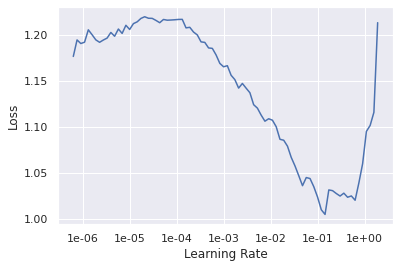

In [200]:
# find the optimal learning rate, just like we did before
tweet_model.lr_find()

# plot it
tweet_model.recorder.plot()

In [201]:
# like we did before, we choose a learning rate before
# the minimum of the graph and use the 1cycle policy
tweet_model.fit_one_cycle(5,1e-1,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.730698,0.643544,0.734825,00:05
1,0.766171,0.664570,0.735205,00:05
2,0.706784,0.519045,0.797800,00:05
3,0.642678,0.515896,0.803490,00:05
4,0.608172,0.514036,0.798938,00:05


In [202]:
# unfreeze next layer
tweet_model.freeze_to(-2)

# train with next layer unfrozen, apply discriminative fine-tuning
tweet_model.fit_one_cycle(5,slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.571712,0.499601,0.806904,00:07
1,0.564838,0.484673,0.812974,00:06
2,0.532750,0.482776,0.820182,00:06
3,0.433466,0.485563,0.816768,00:06
4,0.377282,0.512191,0.816768,00:06


In [203]:
# repeat the process
tweet_model.freeze_to(-3)
tweet_model.fit_one_cycle(5,slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.394812,0.554219,0.788695,00:10
1,0.428202,0.505883,0.811077,00:09
2,0.300300,0.580241,0.809560,00:09
3,0.206116,0.639154,0.807284,00:10
4,0.136368,0.686904,0.811457,00:10


In [204]:
# now unfreeze everything
tweet_model.unfreeze()
tweet_model.fit_one_cycle(5,slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.134904,0.736935,0.797800,00:12
1,0.251663,0.690683,0.808042,00:13
2,0.199317,0.656864,0.803490,00:12
3,0.100751,0.724760,0.814871,00:13
4,0.088088,0.776603,0.822838,00:12


# Prediction Phase

In [205]:
# put test data in test df
df_test = pd.read_csv('twitter_data_cleaned_test.csv')
print(df_test[['text','airline_sentiment']])
df_test.head()

                                                   text airline_sentiment
0      Promotion also said two free round trip fligh...          negative
1      my travel for tomorrow was Cancelled Flightle...          negative
2      I received a brochure in the mail touting all...           neutral
3             is the worst airline to ever travel with.          negative
4      If SNA curfew causes diversion, do you provid...          negative
...                                                 ...               ...
1459   had me at their safety video . . . url  LOVED...          positive
1460   I needed to be at my destination by lunchtime...          negative
1461   Got it, thanks. Any insight into what will ha...           neutral
1462   I would die if I got tickets to DestinationDr...          negative
1463   new flight has me at the window. Kind of tick...          negative

[1464 rows x 2 columns]


,Unnamed: 0,text,airline_sentiment
0,5757,Promotion also said two free round trip fligh...,negative
1,14267,my travel for tomorrow was Cancelled Flightle...,negative
2,11248,I received a brochure in the mail touting all...,neutral
3,9659,is the worst airline to ever travel with.,negative
4,12559,"If SNA curfew causes diversion, do you provid...",negative


In [206]:
# add a column with the predictions on the test set

df_test['sentiment_pred'] = df_test['text'].apply(lambda row:str(tweet_model.predict(row)[0]))


Let us now calculate the accuracy which is a popular evaluation metric in order to compare with many other approaches.

In [207]:
# print the accuracy against the test set
print("Accuracy: {}".format(accuracy_score(df_test['airline_sentiment'],df_test[
    'sentiment_pred'])))

Accuracy: 0.8073770491803278


The result is quite convincing.

Let's see how our model predicts!

In [208]:
import matplotlib.pyplot as plt
# Taken from the scikit-learn documentation
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

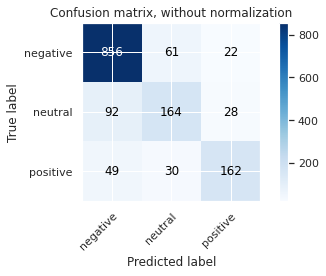

In [209]:
# plot the confusion matrix for the test set
plot_confusion_matrix(df_test['airline_sentiment'],df_test['sentiment_pred'],
                      classes=['negative','neutral','positive'])
plt.show()

Woohooo! That's awesome!

# References
- This Notebook is inspired primarily from the [github repository](https://github.com/rajs96/ULMFiT-Twitter-US-Airline-Sentiment/blob/master/ulmfit_results.ipynb).
- ["Universal Language Model Fine-tuning for Text Classification"](https://arxiv.org/abs/1801.06146) 
- ["A Comparison of Pre-processing Techniques for Twitter Sentiment Analysis"](https://link.springer.com/chapter/10.1007/978-3-319-67008-9_31)
- ["A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, momentum, and weight decay"](https://arxiv.org/abs/1803.09820)